# Import Libraries

In [236]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score


# Load the Data

In [237]:
# Load the data
df = pd.read_csv("cleaned_coursera_dataset.csv")

In [238]:
df.head(0)

,Course Title,Rating,Provider,Level,Reviews,Type,Duration / Weeks


In [239]:
df.drop('Course Title', axis=1, inplace=True)

In [240]:
df.rename(columns={'Duration / Weeks': 'duration_weeks', 'Type': 'course_type'}, inplace=True)

In [241]:
df.rename(columns={'type': 'course_type'}, inplace=True)

In [242]:
df.columns = df.columns.str.lower()

In [243]:
df

,rating,provider,level,reviews,course_type,duration_weeks
0,4.8,Google,Beginner,151000.0,Professional Certificate,12 - 24
1,4.8,Google,Beginner,35000.0,Professional Certificate,12 - 24
2,4.8,Google,Beginner,112000.0,Professional Certificate,12 - 24
3,4.8,Google,Beginner,30000.0,Professional Certificate,12 - 24
4,4.8,Google,Beginner,83000.0,Professional Certificate,12 - 24
...,...,...,...,...,...,...
4299,3.9,LearnQuest,Beginner,32.0,Course,1 - 4
4300,4.8,Autodesk,Intermediate,88.0,Course,1 - 4
4301,4.4,Digital Marketing Institute,Beginner,62.0,Course,1 - 4
4302,3.5,Board Infinity,Intermediate,6.0,Course,1 - 4


In [244]:
df.dtypes

rating            float64
provider           object
level              object
reviews           float64
course_type        object
duration_weeks     object
dtype: object

In [245]:
# Extracting the duration in weeks
# Assuming that the duration is given as a range "min - max", we'll take the average of the range
def extract_weeks(duration):
    try:
        weeks = duration.split(" - ")
        if len(weeks) == 2:
            return (int(weeks[0]) + int(weeks[1])) / 2
        else:
            return int(weeks[0])
    except:
        return None

df['duration_weeks'] = df['duration_weeks'].apply(extract_weeks)

df.head()

,rating,provider,level,reviews,course_type,duration_weeks
0,4.8,Google,Beginner,151000.0,Professional Certificate,18.0
1,4.8,Google,Beginner,35000.0,Professional Certificate,18.0
2,4.8,Google,Beginner,112000.0,Professional Certificate,18.0
3,4.8,Google,Beginner,30000.0,Professional Certificate,18.0
4,4.8,Google,Beginner,83000.0,Professional Certificate,18.0


# Feature Selection

In [246]:
numerical_features = df.select_dtypes(include=['number']).columns

In [247]:
selected_columns = ['rating', 'reviews', 'duration_weeks']
data_clean = df[selected_columns].dropna()
data_clean.head()

,rating,reviews,duration_weeks
0,4.8,151000.0,18.0
1,4.8,35000.0,18.0
2,4.8,112000.0,18.0
3,4.8,30000.0,18.0
4,4.8,83000.0,18.0


In [248]:
data_clean.shape

(4304, 3)

# Preprocessing the Data

In [249]:
categorical_features = df.select_dtypes(include=['object']).columns
categorical_features

Index(['provider', 'level', 'course_type'], dtype='object')

In [250]:
# # Calculate the frequency of each 'Provider'
# type_counts = df['provider'].value_counts()

# # Filter 'provider' values that appear 2 or more times
# df = df[df['provider'].isin(type_counts[type_counts >= 2].index)]

##  Encoding

### Split the rating to 5 categories by quantile

In [251]:
# creating the train data, a copy of the original
df_train = data_clean.copy()

In [252]:
df_train.dtypes

rating            float64
reviews           float64
duration_weeks    float64
dtype: object

In [253]:
# Saving the categorical features in a list
categorical_features = df_train.select_dtypes(include=['object']).columns

In [254]:
# encoder = LabelEncoder()

# # Initialize the LabelEncoder
# label_encoder = LabelEncoder()

# # Apply Label Encoding on each categorical feature
# for col in categorical_features:
#     df_train[col] = label_encoder.fit_transform(df_train[col])

#     # Get the mapping of labels
#     label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

#     # Print out the mappings and their labels
#     print(f"Label Encoding Mapping {col}: {label_mapping}")

In [255]:
categorical_features

Index([], dtype='object')

In [256]:
scaler = MinMaxScaler()
scaler.fit(df_train)
df_scaled = scaler.transform(df_train)

# Building and Training the model

In [257]:
wcss = []
for i in range(2, 20):  
    kmeans = KMeans(n_clusters=i,
                    init='k-means++',
                    max_iter=300,
                    n_init=10,
                    random_state=0)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

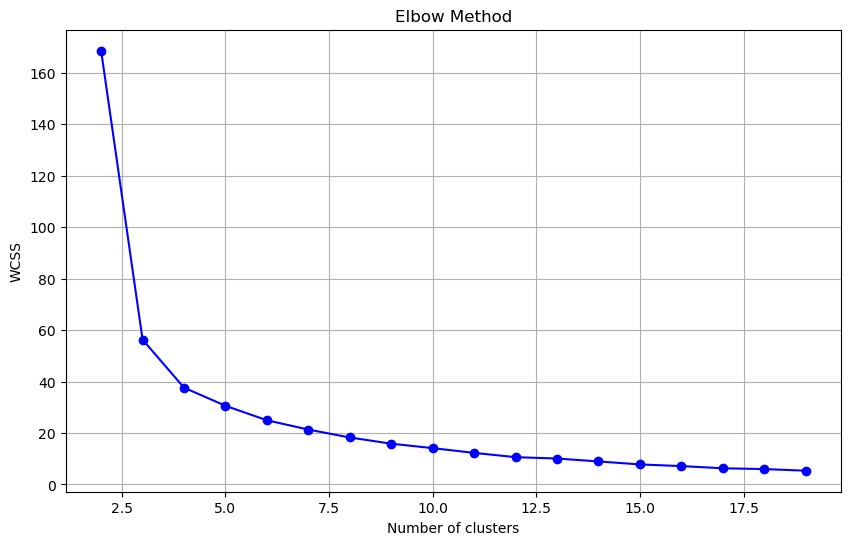

In [258]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 20), wcss,  marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [259]:
# Building the KMeans Model
optimal_clusters = 3

# Initialize and train the KMeans model
best_kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)


In [260]:
# predict
x_kmeans = best_kmeans.fit_predict(df_scaled)

# evaluate model

In [261]:
# Calculate the silhouette score, closer to 1 is better
silhouette_avg = silhouette_score(df_scaled, best_kmeans.labels_)

# Davies-Bouldin Index to evaluate clustering quality.
# Lower values indicate better separation between the clusters.
db_index = davies_bouldin_score(df_scaled, best_kmeans.labels_)

print("Silhouette Score:", silhouette_avg)
print("Davies-Bouldin Index:", db_index)


Silhouette Score: 0.7520316366501715
Davies-Bouldin Index: 0.35567862794312005


In [262]:
inertia = best_kmeans.inertia_
print("Inertia:", inertia)


Inertia: 56.28309249145437


In [263]:
df_train.columns

Index(['rating', 'reviews', 'duration_weeks'], dtype='object')

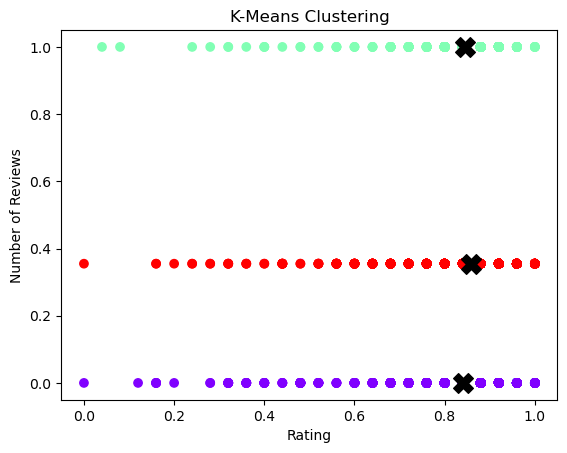

In [264]:
plt.scatter(df_scaled[:, 0], df_scaled[:, 2], c=best_kmeans.labels_, cmap='rainbow')
plt.scatter(best_kmeans.cluster_centers_[:, 0], best_kmeans.cluster_centers_[:, 2], s=200, c='black', marker='X')
plt.title('K-Means Clustering')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()


# Predictions

In [265]:
df_train.columns

Index(['rating', 'reviews', 'duration_weeks'], dtype='object')

- level: {'Advanced': 0, 'Beginner': 1, 'Intermediate': 2, 'Mixed': 3}
- course_type: {'Course': 0, 'Professional Certificate': 1, 'Specialization': 2}
- duration_weeks: {'1 - 4': 0, '12 - 24': 1, '4 - 12': 2}

In [266]:
rating = 5
# provider = 1
# level = 1
reviews = 40000
# course_type = 1
duration = 1

new_data = [[rating, reviews, duration]]  # Replace with your new data points
predictions = best_kmeans.predict(new_data)
print("Predicted clusters for new data:", predictions)


Predicted clusters for new data: [1]


# Clusters Distribution

In [267]:
df_train['Cluster'] = best_kmeans.labels_

In [268]:
cluster_0 = df[df_train['Cluster'] == 0]
cluster_1 = df[df_train['Cluster'] == 1]
cluster_2 = df[df_train['Cluster'] == 2]
cluster_3 = df[df_train['Cluster'] == 3]
cluster_4 = df[df_train['Cluster'] == 4]

In [269]:
cluster_0.shape

(1653, 6)

In [270]:
cluster_1.shape

(724, 6)

In [271]:
cluster_2.shape

(1927, 6)

In [272]:
cluster_3.shape

(0, 6)

In [273]:
cluster_4.shape

(0, 6)

In [274]:
cluster_0['reviews'].mean()

1534.6388384754991

In [275]:
cluster_2['reviews'].mean()

1791.813700051894

In [276]:
cluster_1['reviews'].mean()

6588.013812154696

- Cluster 0 = low
- Cluster 2 = medium
- Cluster 1 = high

In [277]:
import joblib
joblib.dump(best_kmeans, 'kmens_model.joblib')
joblib.dump(scaler, 'kmens_scaler.joblib')

['kmens_scaler.joblib']